# Old or not

## Business Understanding: 
Van volwassen beroemdheden is het vaak lastig te zeggen hoe oud ze zijn. Nu gaan we kijken of we een neuraal netwerk kunnen bouwen wat dit beter kan schatten dan wij. We nemens als grens de compleet arbitraire waarde van 42 jaar. Iedereen tussen de 21 en 42 noemen we 'not old' en iedereen boven deze grens definieren we als 'old' 

We gebruiken hiervoor de IMDB faces database met daarin meer dan 460.000 gezichten van een dikke 20.000 beroemdheden afkomstig van IMDB (zie https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/ voor uitleg en details) en hierbij de IMDB informatie over o.a. leeftijd en geslacht. We downloaden hier de de cropped IMDB dataset( https://data.vision.ee.ethz.ch/cvl/rrothe/imdb-wiki/static/imdb_crop.tar). De metadata wordt in .mat (matlab) bestand meegeleverd. 

- We beperken ons tot volwassen beroemdheden. <u>Iedereen onder de 21 jaar mag je overslaan.</u>
- Er zitten nogal wat foto's met meerdere gezichten of geen gezicht op. <u>Deze mag je eruit filteren</u>
- We verwachten niet alleen de code maar (in het notebook) ook een <u>uitleg</u> van waarom je dingen hebt gedaan. 
- I.v.m. performance issues gebruiken we na opschoning alleen de <u>1e 50.000</u> records als data
- Gebruik <u>20% van je data als testset, gebruik 42 als random state</u>
- Eindig met de mogelijkheid om een jpg van bijv. jezelf in te lezen en d.m.v. het getrainde netwerk te bepalen of diegene wel of niet oud is.

Vul je antwoorden steeds op de juiste plaats in. Maak indien nodig extra cellen aan.

## Data Understanding: 

In [1]:
# Tips:
# - pickle voor tussentijds opslaan

In [10]:
#importeer de juiste packages
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

from sklearn.model_selection import train_test_split

from scipy.io import loadmat

import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import sys
import os
import math

sys.OpenCV_LOADER_DEBUG = True
import cv2


In [3]:
# Constantes
DF_FILTERED_NAME = "cache_df_filtered.feather"  # https://towardsdatascience.com/the-best-format-to-save-pandas-data-414dca023e0d
COUNT_OF_FACES_TO_TRAIN_AND_TEST_ON = 50000

# afbeeldingen
WIDTH = HEIGHT = 100
SIZE = (WIDTH, HEIGHT)


In [4]:
#Lees de metadata in

mat = loadmat("imdb_crop/imdb.mat", squeeze_me=True)

In [5]:
# bestudeer deze en maak voor iedere relevante variabele een aparte list aan
mat: dict = mat
imdb: np.ndarray = mat["imdb"]

(dob, photo_taken, full_path, gender, name, face_location, face_score, second_face_score, celeb_names, celeb_id) = imdb.tolist()

dob1 = dob[0]
print(dob1, type(dob1))

def convertDate(date):
    EPOCH = 719529
    return pd.to_datetime(int(date) - EPOCH, unit='D')

693726 <class 'numpy.int32'>


## Data preparation: 

In [6]:
#Bepaal op basis van de metadata hoe oud de personen op de foto's waren toen deze genomen werden (-1 als onbekend)

age_on_photo = []
# invalids = 0
for i in range(0, len(dob)):
    try:
        date = convertDate(dob[i])
        ageThen = photo_taken[i] - date.year
        age_on_photo.append(ageThen)
    except Exception as e:
        # invalids += 1
        age_on_photo.append(-1)

# print(invalids, "zijn/is ongeldig, dit is", (float(invalids)/len(dob)*100), "procent")

In [7]:
#voeg de ingelezen metadata en de berekende leeftijd samen tot een nieuwe dataset

df = pd.DataFrame(data={
    'name': name,
    'full_path': full_path,
    'age_on_photo': age_on_photo,
    'face_score': face_score,
    'second_face_score': second_face_score,
})

In [8]:
#schoon de dataset op op basis van de bij de business understanding gegeven criteria.

OLDNESS_THRESHOLD = 42

## Filter: check of mensen minsten 21 jaar oud zijn
df_filtered = df[df['age_on_photo'] >= 21]

## Filter: alleen foto's waar gezichten op gevonden zijn
#       face_score: detector score (the higher the better).
#                   Inf implies that no face was found in the image and the face_location then just returns the entire image
df_filtered = df_filtered[df_filtered['face_score'] != np.Infinity]
df_filtered = df_filtered[df_filtered['face_score'] != -np.Infinity]

## Filter: alleen foto's waar maar een gezicht op staat
##      second_face_score: detector score of the face with the second highest score.
#                          This is useful to ignore images with more than one face.
#                          second_face_score is NaN if no second face was detected.
df_filtered = df_filtered[pd.isna(df_filtered['second_face_score'])]

df_filtered['oldness'] = df_filtered.apply(lambda row: int(row.age_on_photo >= OLDNESS_THRESHOLD), axis=1)

## Filter: max 50000
df_filtered = df_filtered.head(COUNT_OF_FACES_TO_TRAIN_AND_TEST_ON)

print(f"Gemiddelde oudheid: {df_filtered['oldness'].mean()}")

df_filtered.info()
df_filtered.head()

df_filtered.to_feather(DF_FILTERED_NAME)

Gemiddelde oudheid: 0.55768
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 3 to 125817
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   name               50000 non-null  object 
 1   full_path          50000 non-null  object 
 2   age_on_photo       50000 non-null  int64  
 3   face_score         50000 non-null  float64
 4   second_face_score  0 non-null      float64
 5   oldness            50000 non-null  int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 2.7+ MB


![img](imdb_crop/01/nm0000001_rm946909184_1899-5-10_1968.jpg)

In [11]:
# Lees de afbeeldingen in

def readImage(path: str):
    cachePath = path.replace("jpg", "cached.jpg")
    if os.path.exists(cachePath):
        return cv2.imread(cachePath)

    img = cv2.imread(path)
    # Cursed conversion van BGR naar RGB
    img = img[...,::-1]

    img = cv2.resize(img, SIZE)

    # img = img / 255.0
    cv2.imwrite(cachePath, img)
    return img

images = [readImage("imdb_crop/" + path) for path in df_filtered['full_path']]


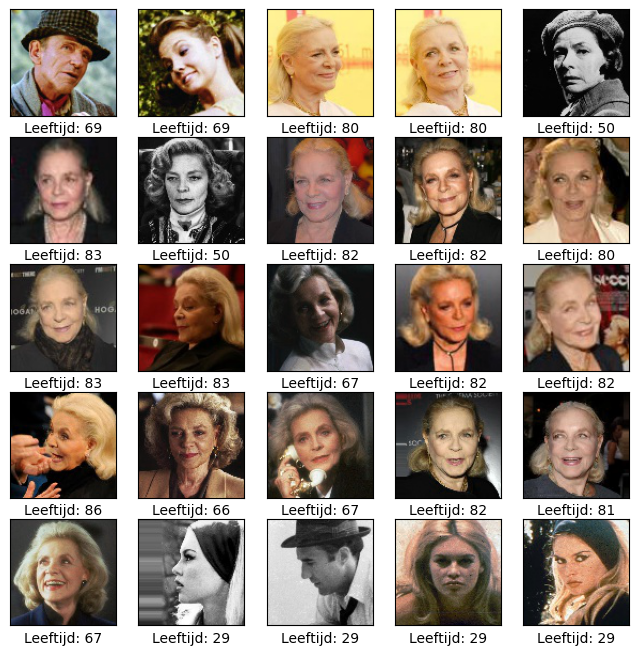

In [14]:
# Check of de afbeeldingen oke zijn
plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)  #vul het i-e image
    plt.xticks([]) #geen schaal bij x-as
    plt.yticks([]) #geen schaal bij y-as
    plt.imshow(images[i]) #orginele plaatjes nodig want de rest zit in een genormaliseerde vector
    plt.xlabel(f'Leeftijd: {df_filtered.iloc[i]["age_on_photo"]}')
plt.show()

In [15]:
widths = np.array([img.shape[0] for img in images])
heights = np.array([img.shape[1] for img in images])

print(f"Width van {widths.min()} naar {widths.max()}")
print(f"Height van {heights.min()} naar {heights.max()}")

Width van 100 naar 100
Height van 100 naar 100


## Modeling: 

In [16]:

images_resized = np.array([cv2.resize(img, SIZE) for img in images])

In [17]:
images_resized_scaled = images_resized
# images_reshaped = images_resized_scaled.reshape((COUNT, WIDTH * HEIGHT * 3))
# images_reshaped.shape

In [18]:
ages = np.array(df_filtered['oldness'])
ages.shape

age_on_photos = np.array(df_filtered['age_on_photo'])
age_on_photos.shape

names = np.array(df_filtered['name'])
names.shape

(50000,)

In [19]:
indices = np.arange(0, COUNT_OF_FACES_TO_TRAIN_AND_TEST_ON)
train_images, test_images, train_ages, test_ages, train_age_on_photos, test_age_on_photos, train_names, test_names, train_indices, test_indices  = train_test_split(images_resized_scaled, ages, age_on_photos, names, indices, test_size=0.2, random_state=42)
ages

array([1, 1, 1, ..., 0, 0, 0])

(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)
(100, 100, 3)


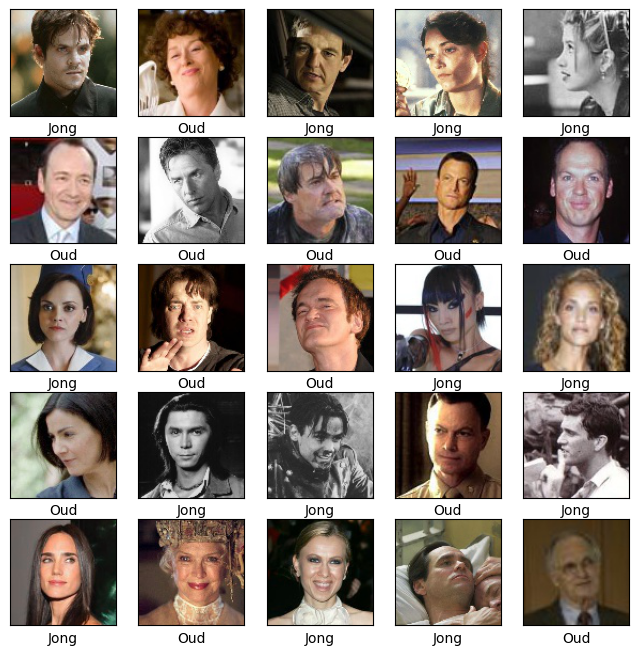

In [20]:
# en valideer dit op de testdata

plt.figure(figsize=(8,8))
for i in range(min(25, len(train_images))):
    plt.subplot(5,5,i+1)  #vul het i-e image
    plt.xticks([]) #geen schaal bij x-as
    plt.yticks([]) #geen schaal bij y-as
    plt.imshow(train_images[i]) #orginele plaatjes nodig want de rest zit in een genormaliseerde vector
    plt.xlabel("Oud" if train_ages.tolist()[i] == 1 else "Jong")
    print(train_images[i].shape)
plt.show()

In [21]:

train_datagen = ImageDataGenerator(
    # rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    # vertical_flip=True,
)

data_flow = train_datagen.flow(train_images, tf.reshape(train_ages, (-1)), shuffle=True)

I0000 00:00:1726770731.917573    4950 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726770732.098131    4950 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726770732.098357    4950 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1726770732.099602    4950 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [37]:
# checkpoints zodat wanneer Jupyter crasht, ik niet weer 20min moet wachten

checkpoint_path = "training_1/cp.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)

batch_size = 64

n_batches = math.ceil(len(train_images) / batch_size)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 save_freq=n_batches,
                                                 verbose=1)


In [38]:

# train het model
model = models.Sequential([
    layers.Dense(64, activation='relu', kernel_regularizer="l1"),
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(WIDTH, HEIGHT, 3), padding="SAME"),
    layers.BatchNormalization(),
    layers.MaxPooling2D((3, 3)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((3, 3)),
    layers.Flatten(),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax'),
])

model.compile(optimizer="ADAM",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

if os.path.exists(checkpoint_path):
    latest_weights = tf.train.latest_checkpoint(checkpoint_dir)
    model.load_weights(latest_weights)

loss, acc = model.evaluate(test_images, test_ages, verbose=2)
print("Huidige accuracy van het model is: {:5.2f}%".format(100 * acc))


/data/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1726771103.927483   13059 service.cc:146] XLA service 0x7f24e80043c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726771103.927521   13059 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-09-19 20:38:23.959154: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-19 20:38:24.050014: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
I0000 00:00:1726771105.158058   13059

313/313 - 3s - 11ms/step - accuracy: 1.0000e-04 - loss: 43.9702
Huidige accuracy van het model is:  0.01%


In [39]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 100, 100, 64)   │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 100, 100, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100, 100, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 33, 33, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 31, 31, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 31, 31, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        64,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,634 (541.54 KB)

 Trainable params: 138,378 (540.54 KB)

 Non-trainable params: 256 (1.00 KB)

In [40]:
history = model.fit(data_flow,
                    epochs=50,
                    validation_data=(test_images, test_ages),
                    batch_size=batch_size,
                    callbacks=[cp_callback])

Epoch 1/50


/data/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 624/1250 ━━━━━━━━━━━━━━━━━━━━ 23s 38ms/step - accuracy: 0.5449 - loss: 1.4279
Epoch 1: saving model to training_1/cp.weights.h5
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5483 - loss: 1.3102
Epoch 1: saving model to training_1/cp.weights.h5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 55s 40ms/step - accuracy: 0.5483 - loss: 1.3099 - val_accuracy: 0.5781 - val_loss: 0.8769
Epoch 2/50
 624/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 36ms/step - accuracy: 0.5611 - loss: 0.8726
Epoch 2: saving model to training_1/cp.weights.h5
1247/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5619 - loss: 0.8544
Epoch 2: saving model to training_1/cp.weights.h5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 47s 37ms/step - accuracy: 0.5620 - loss: 0.8542 - val_accuracy: 0.5711 - val_loss: 0.7821
Epoch 3/50
 624/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 35ms/step - accuracy: 0.5878 - loss: 0.7208
Epoch 3: saving model to training_1/cp.weights.h5
1249/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5882 - loss: 0.7128
Epoch 3: saving

In [41]:
# en valideer dit op de testdata
loss, acc = model.evaluate(test_images, test_ages, verbose=2)
print("Accuracy van het model is na het trainen: {:5.2f}%".format(100 * acc))

313/313 - 1s - 4ms/step - accuracy: 0.6406 - loss: 0.6384
Accuracy van het model is na het trainen: 64.06%


## Evaluation: 

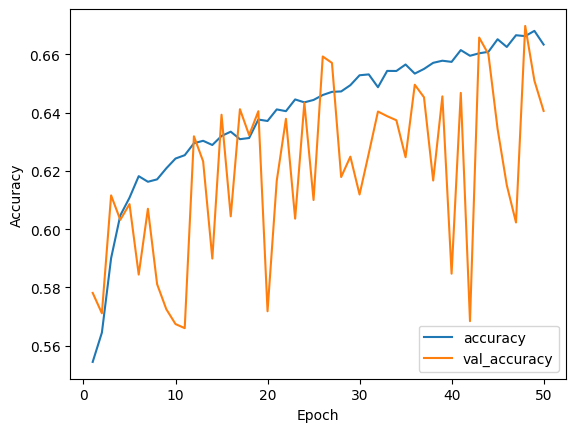

In [42]:
#plot de accuracy en validated accuracy
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
epochs=range(1, len(acc)+1)
plt.plot(epochs, acc, label='accuracy')
plt.plot(epochs, val_acc, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


<Axes: >

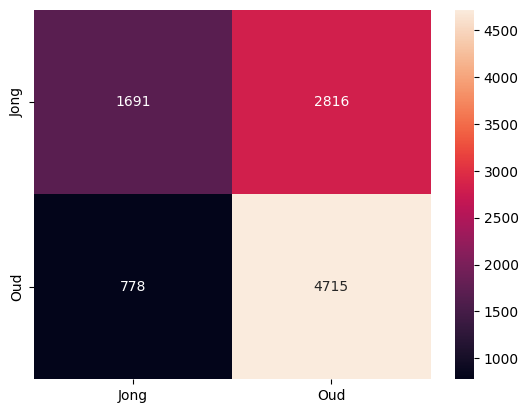

In [43]:
#toon de confusion matrix,
Y_predict= []
predict=model.predict([test_images]) #2d array
for i in range (len(predict)):
    Y_predict.append(predict[i].argmax()) #omzetten zodat ik alleen de max waarde krijg
cm=confusion_matrix(test_ages, Y_predict)
#print(cm) #lelijk maar functioneel

sns.heatmap(cm, annot=True, fmt='d', xticklabels=["Jong", "Oud"], yticklabels=["Jong", "Oud"])
# fmt='g' om te voorkomen dat de wetenschappelijke notatie (3.7e+02) gebruikt.

![Img](imdb_crop/93/nm0000093_rm3278212608_1963-12-18_2009.jpg)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 635ms/step


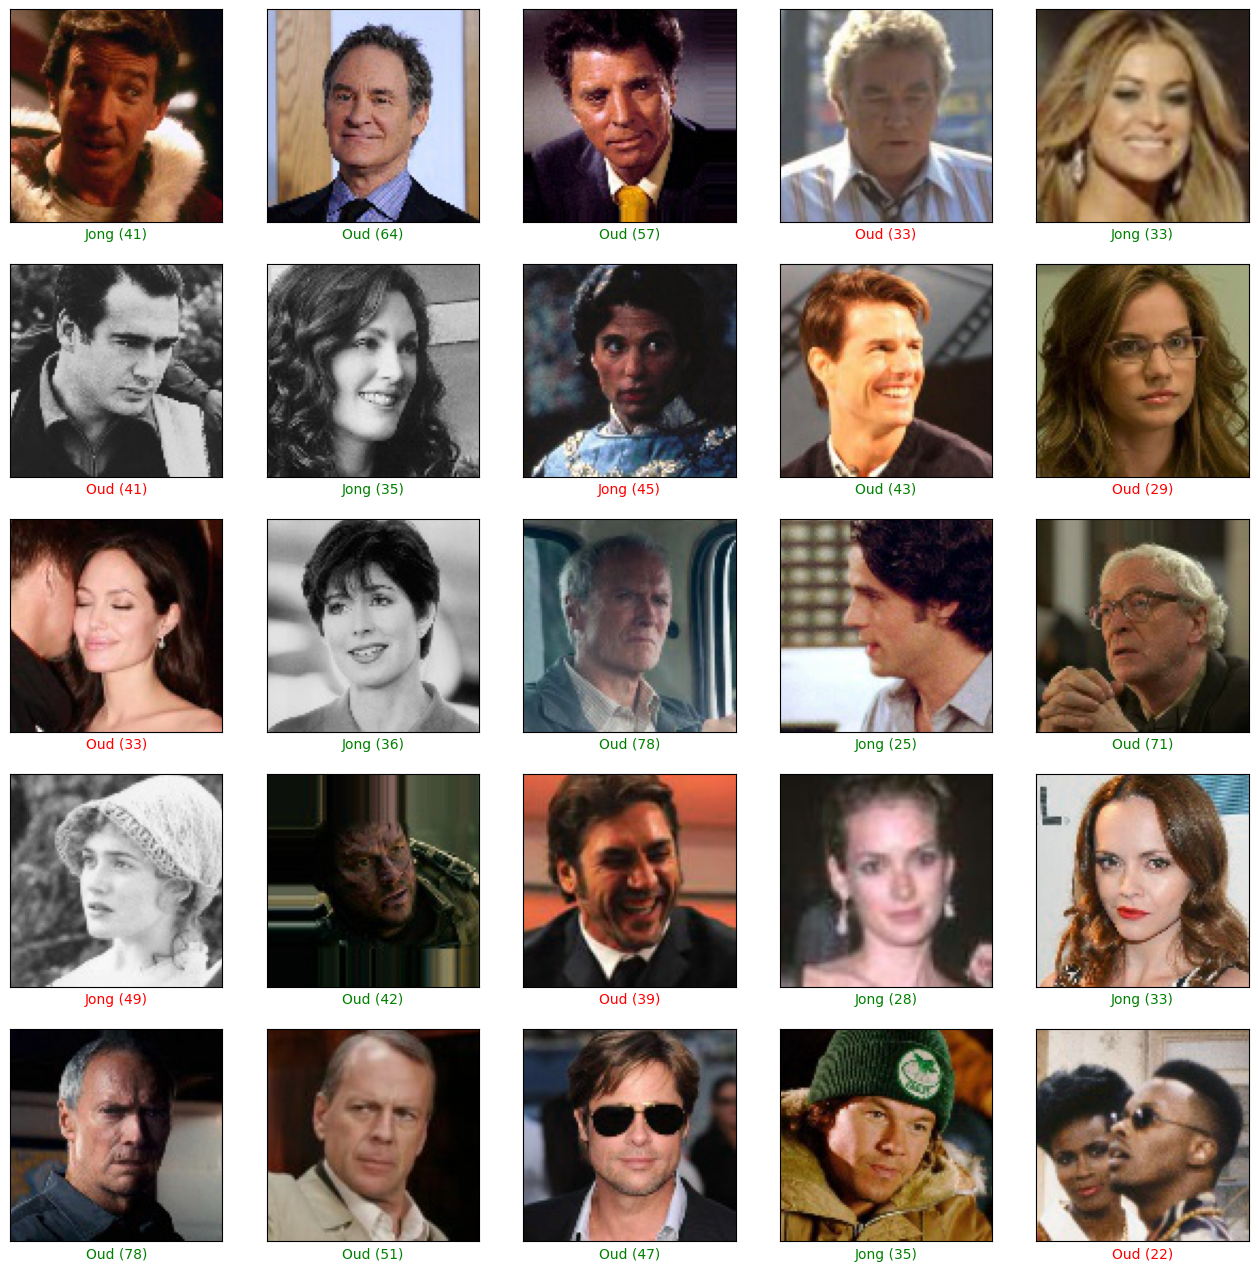

In [44]:
# en toon de een aantal afbeeldingen inclusief of ze volgens het model wel of niet oud zijn,
# doe dit laatste ook voor een paar eigen afbeeldingen


predict = model.predict(test_images[0:25])

predict.shape
plt.figure(figsize = (16, 16))
for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(test_images[i])

    prediction = round(predict[i].argmax())
    actual = round(test_ages[i])

    label = "Oud" if prediction == 1 else "Jong"
    label += f' ({test_age_on_photos[i]})'

    ax.xaxis.label.set_color('green' if prediction == actual else 'red')

    plt.xlabel(label)

    # ax = plt.subplot(10, 10, i * 2 + 2)
    # plt.xticks([])
    # plt.yticks([])
    # print(test_indices[i])
    # plt.xlabel(test_names[i])
plt.show()

Kunnen we met dit model betrouwbaar schatten of een beroemdheid oud is?
(type je antwoord en uitleg hieronder)

In [45]:
tristan = readImage('1704671510929.jpeg')
tristan = cv2.resize(tristan, SIZE)
tristan = np.array([tristan])
tristan = tristan / 255.0
# tristan = tristan.reshape(WIDTH * HEIGHT * 3)
tristan.shape

(1, 100, 100, 3)

In [46]:
predict = model.predict([tristan])
predict: np.ndarray = predict[0]
predict = predict.argmax()
schatting = "oud" if predict == 1 else "jong"
print(f"Ik ben {schatting}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
Ik ben oud


In [47]:
natalie = readImage('natalie.jpg')
natalie = cv2.resize(natalie, SIZE)
natalie = np.array([natalie])
natalie = natalie / 255.0
# tristan = tristan.reshape(WIDTH * HEIGHT * 3)
natalie.shape

predict = model.predict([natalie])
predict: np.ndarray = predict[0]
predict = predict.argmax()
schatting = "oud" if predict == 1 else "jong"
print(f"Natalie is {schatting}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Natalie is oud
